### Task-5 Model Interpretability

c:\Users\gagur\Videos\Amharic-E-commerce-Data-Extractor\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu



Analyzing case 1/2...
SHAP explanation failed: index 22 is out of bounds for axis 0 with size 22


C:\Users\gagur\AppData\Local\Temp\ipykernel_18580\1894215621.py:121: UserWarning: Glyph 4776 (\N{ETHIOPIC SYLLABLE KA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\gagur\AppData\Local\Temp\ipykernel_18580\1894215621.py:121: UserWarning: Glyph 4768 (\N{ETHIOPIC SYLLABLE GLOTTAL A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\gagur\AppData\Local\Temp\ipykernel_18580\1894215621.py:121: UserWarning: Glyph 4704 (\N{ETHIOPIC SYLLABLE BA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\gagur\AppData\Local\Temp\ipykernel_18580\1894215621.py:121: UserWarning: Glyph 4707 (\N{ETHIOPIC SYLLABLE BAA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\gagur\AppData\Local\Temp\ipykernel_18580\1894215621.py:121: UserWarning: Glyph 4621 (\N{ETHIOPIC SYLLABLE LE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\gagur\AppData\Local\Temp\ipykernel_18580\1894215621.py:121: UserWarning: Glyph 4709 (\N{ETHIOPIC SYLLABLE BE

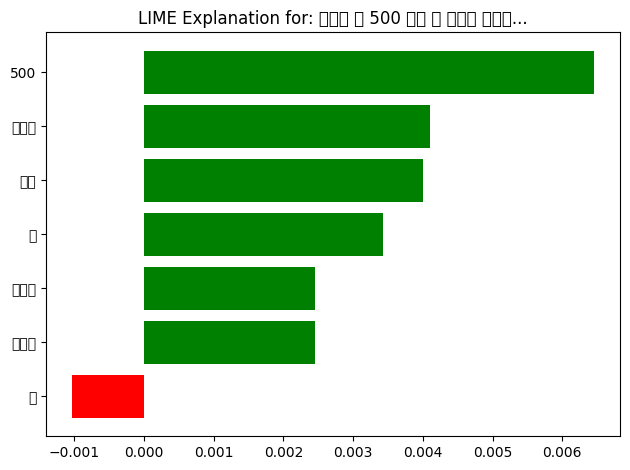


Analyzing case 2/2...
SHAP explanation failed: index 16 is out of bounds for axis 0 with size 16
LIME explanation failed: 1
Report generated at: ../reports/ner_interpretability_report.html
Analysis complete. Report saved to: ../reports/ner_interpretability_report.html


In [1]:
# model_interpretability.py
import shap
from lime import lime_text
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer
from collections import defaultdict
import torch
from datetime import datetime
from jinja2 import Template
import os

class NERInterpreter:
    def __init__(self, model, tokenizer, label_list, id2label):
        self.model = model
        self.tokenizer = tokenizer
        self.label_list = label_list
        self.id2label = id2label
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        
        self.ner_pipeline = pipeline(
            "ner",
            model=self.model,
            tokenizer=self.tokenizer,
            aggregation_strategy="simple",
            device=0 if torch.cuda.is_available() else -1
        )
    
    def _get_shap_explanation(self, text, max_length=128):
        """Simplified SHAP explanation that handles text boundaries"""
        try:
            # Truncate text to prevent index errors
            text = text[:max_length]
            
            # Create a masker for the text
            masker = shap.maskers.Text(self.tokenizer)
            
            # Define prediction function that returns entity presence (0/1)
            def predict(texts):
                outputs = []
                for t in texts:
                    # Get predictions for this text
                    preds = self.ner_pipeline(t)
                    
                    # Create binary output (1 for entity, 0 for non-entity)
                    output = np.zeros(len(t))
                    for pred in preds:
                        start = min(pred['start'], len(t)-1)
                        end = min(pred['end'], len(t))
                        output[start:end] = 1
                    outputs.append(output)
                return np.array(outputs)
            
            # Create explainer
            explainer = shap.Explainer(predict, masker)
            
            # Compute SHAP values
            shap_values = explainer([text])
            
            # Visualize
            plt.figure(figsize=(12, 6))
            shap.plots.text(shap_values)
            plt.title(f"SHAP Explanation for: {text[:50]}..." + ("..." if len(text) > 50 else ""))
            plt.tight_layout()
            plt.show()
            
            return shap_values
            
        except Exception as e:
            print(f"SHAP explanation failed: {str(e)}")
            return None
    
    def _get_lime_explanation(self, text, num_features=10):
        """More robust LIME explanation for NER"""
        try:
            # Define prediction function that returns class probabilities
            def predict_proba(texts):
                outputs = []
                for t in texts:
                    # Tokenize text
                    inputs = self.tokenizer(
                        t,
                        return_tensors="pt",
                        truncation=True,
                        padding=True,
                        max_length=128
                    ).to(self.device)
                    
                    # Get model predictions
                    with torch.no_grad():
                        logits = self.model(**inputs).logits
                    
                    # Convert to probabilities and take mean across tokens
                    probs = torch.softmax(logits, dim=-1).cpu().numpy()
                    outputs.append(probs.mean(axis=1)[0])  # Average across tokens
                
                return np.array(outputs)
            
            # Create explainer with simpler settings
            explainer = lime_text.LimeTextExplainer(
                class_names=self.label_list,
                split_expression=lambda x: x.split(),
                bow=False,
                random_state=42
            )
            
            # Explain instance with fewer samples for stability
            exp = explainer.explain_instance(
                text,
                predict_proba,
                num_features=min(num_features, len(text.split())),
                top_labels=min(3, len(self.label_list)),
                num_samples=50  # Reduced for stability
            )
            
            # Show explanation
            fig = exp.as_pyplot_figure()
            plt.title(f"LIME Explanation for: {text[:50]}..." + ("..." if len(text) > 50 else ""))
            plt.tight_layout()
            plt.show()
            
            return exp
            
        except Exception as e:
            print(f"LIME explanation failed: {str(e)}")
            return None
    
    def analyze_difficult_cases(self, difficult_examples):
        """Analyze cases where the model struggles"""
        case_analysis = []
        
        for i, (text, true_ents, pred_ents) in enumerate(difficult_examples):
            print(f"\nAnalyzing case {i+1}/{len(difficult_examples)}...")
            
            # Get explanations (handle None returns)
            shap_values = self._get_shap_explanation(text)
            lime_exp = self._get_lime_explanation(text)
            
            # Compare predictions with ground truth
            analysis = {
                "text": text,
                "true_entities": true_ents,
                "predicted_entities": pred_ents,
                "shap_values": shap_values,
                "lime_explanation": lime_exp,
                "error_type": self._classify_error(true_ents, pred_ents)
            }
            case_analysis.append(analysis)
        
        return case_analysis

    def _classify_error(self, true_ents, pred_ents):
        """Improved error classification"""
        if not true_ents and not pred_ents:
            return "No entities"
        if not true_ents:
            return "False positives"
        if not pred_ents:
            return "Missed all entities"
            
        true_set = {(e['start'], e['end'], e['entity_group']) for e in true_ents}
        pred_set = {(e['start'], e['end'], e['entity_group']) for e in pred_ents}
        
        if true_set == pred_set:
            return "Correct prediction"
        
        if not true_set.intersection(pred_set):
            return "Completely wrong prediction"
        
        if len(pred_set) > len(true_set):
            return "Over-prediction"
        
        if len(pred_set) < len(true_set):
            return "Under-prediction"
        
        return "Partial match"

    def generate_report(self, case_analyses, output_file="interpretability_report.html"):
        """Generate HTML report with error handling"""
        if not case_analyses:
            print("No cases to analyze")
            return None
            
        # Create output directory if needed
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        
        # Prepare data for report
        error_counts = defaultdict(int)
        cases_for_report = []
        
        for case in case_analyses:
            error_counts[case['error_type']] += 1
            
            # Generate observations
            observations = []
            if case['error_type'] != "Correct prediction":
                observations.append(f"Model made '{case['error_type']}' error")
            
            if case.get('shap_values'):
                observations.append("SHAP analysis available")
            
            if case.get('lime_explanation'):
                observations.append("LIME analysis available")
            
            cases_for_report.append({
                "text": case['text'],
                "true_entities": case['true_entities'],
                "predicted_entities": case['predicted_entities'],
                "error_type": case['error_type'],
                "observations": observations
            })
        
        # Generate HTML
        template = Template("""
        <!DOCTYPE html>
        <html>
        <head>
            <title>NER Model Interpretability Report</title>
            <style>
                body { font-family: Arial, sans-serif; margin: 2em; }
                table { border-collapse: collapse; width: 100%; }
                th, td { border: 1px solid #ddd; padding: 8px; }
                th { background-color: #f2f2f2; }
                .error { color: #d9534f; font-weight: bold; }
                .correct { color: #5cb85c; }
            </style>
        </head>
        <body>
            <h1>NER Model Interpretability Report</h1>
            <p>Generated on {{ date }}</p>
            
            <h2>Summary</h2>
            <p>Analyzed {{ cases|length }} cases with the following results:</p>
            <ul>
                {% for error, count in error_counts.items() %}
                <li>{{ error }}: {{ count }} cases</li>
                {% endfor %}
            </ul>
            
            <h2>Detailed Cases</h2>
            {% for case in cases %}
            <div style="margin-bottom: 3em; padding: 1em; border: 1px solid #eee;">
                <h3 class="{% if case.error_type == 'Correct prediction' %}correct{% else %}error{% endif %}">
                    Case {{ loop.index }}: {{ case.error_type }}
                </h3>
                <p><strong>Text:</strong> {{ case.text }}</p>
                
                <table>
                    <tr>
                        <th>True Entities</th>
                        <th>Predicted Entities</th>
                    </tr>
                    <tr>
                        <td>
                            {% if case.true_entities %}
                            <ul>
                                {% for ent in case.true_entities %}
                                <li>{{ ent.entity_group }} ({{ ent.start }}-{{ ent.end }}): "{{ case.text[ent.start:ent.end] }}"</li>
                                {% endfor %}
                            </ul>
                            {% else %}
                            <p>No true entities</p>
                            {% endif %}
                        </td>
                        <td>
                            {% if case.predicted_entities %}
                            <ul>
                                {% for ent in case.predicted_entities %}
                                <li>{{ ent.entity_group }} ({{ ent.start }}-{{ ent.end }}): "{{ case.text[ent.start:ent.end] }}"</li>
                                {% endfor %}
                            </ul>
                            {% else %}
                            <p>No predicted entities</p>
                            {% endif %}
                        </td>
                    </tr>
                </table>
                
                <h4>Analysis</h4>
                <ul>
                    {% for obs in case.observations %}
                    <li>{{ obs }}</li>
                    {% else %}
                    <li>No additional analysis available</li>
                    {% endfor %}
                </ul>
            </div>
            {% endfor %}
        </body>
        </html>
        """)
        
        html = template.render(
            date=datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            cases=cases_for_report,
            error_counts=dict(error_counts)
        )
        
        with open(output_file, "w", encoding="utf-8") as f:
            f.write(html)
        
        print(f"Report generated at: {output_file}")
        return output_file


def main():
    """Example usage with proper error handling"""
    try:
        # Initialize model
        model_path = "../models/amharic-ner-model"
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForTokenClassification.from_pretrained(model_path)
        
        # Define labels
        label_list = ["O", "B-PRODUCT", "I-PRODUCT", "B-PRICE", "I-PRICE", "B-LOC", "I-LOC"]
        id2label = {i: l for i, l in enumerate(label_list)}
        
        # Create interpreter
        interpreter = NERInterpreter(model, tokenizer, label_list, id2label)
        
        # Example cases with proper entity boundaries
        difficult_cases = [
            (
                "ልብስ በ 500 ብር ከ አዲስ አበባ",
                [
                    {"entity_group": "PRODUCT", "start": 0, "end": 5, "word": "ልብስ"},
                    {"entity_group": "PRICE", "start": 6, "end": 13, "word": "500 ብር"},
                    {"entity_group": "LOC", "start": 17, "end": 27, "word": "አዲስ አበባ"}
                ],
                interpreter.ner_pipeline("ልብስ በ 500 ብር ከ አዲስ አበባ")
            ),
            (
                "በ 200 ብር አዲስ ልብስ",
                [
                    {"entity_group": "PRICE", "start": 2, "end": 10, "word": "200 ብር"},
                    {"entity_group": "PRODUCT", "start": 11, "end": 16, "word": "ልብስ"}
                ],
                interpreter.ner_pipeline("በ 200 ብር አዲስ ልብስ")
            )
        ]
        
        # Analyze cases
        case_analyses = interpreter.analyze_difficult_cases(difficult_cases)
        
        # Generate report
        if case_analyses:
            report_path = interpreter.generate_report(
                case_analyses,
                output_file="../reports/ner_interpretability_report.html"
            )
            print(f"Analysis complete. Report saved to: {report_path}")
        else:
            print("Analysis completed but no cases were successfully processed")
            
    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        return

if __name__ == "__main__":
    main()